# AI Pill Image Retrieval with CLIP Embeddings & Nearest Neighbors

#### Students: Franck Kolontchang, Tobi Adejare, Mahdi Mohammad

This notebook builds an **image-based pill identification helper** using the **NIH C3PI / RxImage** dataset.

This code:

1. **Embed each pill image** using a pre-trained vision–language model (**CLIP**).
2. Build a **nearest-neighbor index** over all image embeddings.
3. For a **new pill image**, retrieve the **top-k visually most similar pills** and show their metadata (NDC, RxCUI, name, etc.).

You can then use this as a practical pill lookup tool or as a baseline for more advanced systems.

In [1]:
import os
import re
import gc
import sys
import time
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import math

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF


from PIL import Image
from pathlib import Path
from datetime import datetime
from collections import Counter
from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader


# Vision Transformer
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.preprocessing import LabelEncoder

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Paths
ROOT = Path(".").resolve()
RXIMAGE_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/rximage").resolve()        # Place 'rximage' folder here
print(RXIMAGE_ROOT)
RESOLUTION = "1024"                    # Use the 1024px images subset
OUTPUT_DIR = ROOT / "outputs"
MODELS_DIR = OUTPUT_DIR / "models"
PLOTS_DIR = OUTPUT_DIR / "plots"
DATA_ANALYSIS_DIR = OUTPUT_DIR / "data"

for d in [OUTPUT_DIR, MODELS_DIR, PLOTS_DIR, DATA_ANALYSIS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

from google.colab import drive
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')  # Mount Google Drive
else:
    print("Google Drive is already mounted. Proceeding...")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


/content/drive/MyDrive/Colab Notebooks/rximage
Mounting Google Drive...
Mounted at /content/drive
Device: cuda


Step 2 - Load RxImage

In [2]:
#####
# Step 2: Load RxImage (1024px) and Build DataFrame
# Description: Scan 'rximage' for images (prioritizing 1024px paths), extract NDC codes
# when possible, attach basic metadata, and create df_merged.
#####

def find_images_1024(root: Path, res_folder: str = "1024"):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    files = []
    # Prefer .../<anything>/1024/**/*
    for ext in exts:
        files += list(root.glob(f"**/{res_folder}/**/{ext}"))
    # Fallback to .../1024/*.*
    for ext in exts:
        files += list((root / res_folder).glob(f"**/{ext}"))
    # Make unique and sort
    paths = sorted(set([p.resolve() for p in files]))
    return paths

def extract_ndc_from_text(txt: str):
    # Common NDC patterns (5-4-2, 5-3-2, 4-4-2 with hyphens)
    m = re.search(r"\b\d{5}-\d{4}-\d{2}\b|\b\d{5}-\d{3}-\d{2}\b|\b\d{4}-\d{4}-\d{2}\b", txt)
    return m.group(0) if m else None

cached_csv = DATA_ANALYSIS_DIR / "df_merged.csv"
if cached_csv.exists():
    df_merged = pd.read_csv(cached_csv)
    # Ensure required columns exist
    for col in ["full_path", "ndc11", "name", "image_type"]:
        if col not in df_merged.columns:
            df_merged[col] = ""
    print(f"Loaded cached dataset: {cached_csv} ({len(df_merged):,} rows)")
else:
    assert RXIMAGE_ROOT.exists(), f"rximage folder not found at: {RXIMAGE_ROOT}"
    img_paths = find_images_1024(RXIMAGE_ROOT, RESOLUTION)
    assert len(img_paths) > 0, f"No images found under {RXIMAGE_ROOT} for resolution '{RESOLUTION}'."

    rows = []
    for p in img_paths:
        ndc = extract_ndc_from_text(str(p))
        rows.append({
            "full_path": str(p),
            "ndc11": ndc if ndc else "UNKNOWN",
            "name": ndc if ndc else "UNKNOWN",
            "image_type": "RXNAV"
        })
    df_merged = pd.DataFrame(rows)

    # If any metadata CSV exists with ndc/name, try to merge (best effort)
    possible_meta = list(RXIMAGE_ROOT.glob("**/*.csv"))
    meta = None
    for mpath in possible_meta:
        try:
            tmp = pd.read_csv(mpath, nrows=5)
            cols = {c.lower(): c for c in tmp.columns}
            if ("ndc11" in cols or "ndc" in cols) and ("name" in cols or "drugname" in cols or "brandname" in cols):
                meta = pd.read_csv(mpath)
                break
        except Exception:
            pass
    if meta is not None:
        meta_cols = {c.lower(): c for c in meta.columns}
        ndc_col = meta_cols.get("ndc11") or meta_cols.get("ndc")
        name_col = meta_cols.get("name") or meta_cols.get("drugname") or meta_cols.get("brandname")
        if ndc_col and name_col:
            meta_sub = meta[[ndc_col, name_col]].drop_duplicates()
            meta_sub.columns = ["ndc11", "name"]
            df_merged = df_merged.merge(meta_sub, on="ndc11", how="left", suffixes=("", "_meta"))
            df_merged["name"] = df_merged["name_meta"].combine_first(df_merged["name"])
            df_merged.drop(columns=[c for c in df_merged.columns if c.endswith("_meta")], inplace=True)

    df_merged.to_csv(cached_csv, index=False)
    print(f"Built dataset from images: {len(df_merged):,} rows; cached to {cached_csv}")

# Normalize types
df_merged["full_path"] = df_merged["full_path"].astype(str)
df_merged["ndc11"] = df_merged["ndc11"].astype(str)
df_merged["name"] = df_merged["name"].fillna(df_merged["ndc11"]).astype(str)
if "image_type" not in df_merged.columns:
    df_merged["image_type"] = "RXNAV"

# Remove rows with non-existent files
before = len(df_merged)
df_merged = df_merged[df_merged["full_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
removed = before - len(df_merged)
if removed > 0:
    print(f"Removed {removed} rows with missing files.")


# Step 2C: Enrich metadata from table.csv (if present)
TABLE_CSV_PATH = ROOT / "table.csv"
if TABLE_CSV_PATH.exists():
    meta = pd.read_csv(TABLE_CSV_PATH, dtype=str, low_memory=False)
    meta_cols = {c.lower(): c for c in meta.columns}

    ndc_col = meta_cols.get("ndc11")
    name_col = meta_cols.get("name")
    rxnav_col = meta_cols.get("rxnavimagefilename")
    nlm_col  = meta_cols.get("nlmimagefilename")

    meta_long_parts = []
    if ndc_col and name_col and rxnav_col and rxnav_col in meta.columns:
        m1 = meta[[ndc_col, name_col, rxnav_col]].dropna()
        m1.columns = ["ndc11", "name", "file_name"]
        m1["image_type_csv"] = "RXNAV"
        meta_long_parts.append(m1)
    if ndc_col and name_col and nlm_col and nlm_col in meta.columns:
        m2 = meta[[ndc_col, name_col, nlm_col]].dropna()
        m2.columns = ["ndc11", "name", "file_name"]
        m2["image_type_csv"] = "NLM"
        meta_long_parts.append(m2)

    if meta_long_parts:
        meta_long = pd.concat(meta_long_parts, ignore_index=True)
        meta_long["file_name_lower"] = meta_long["file_name"].str.lower().str.strip()

        df_merged["basename_lower"] = df_merged["full_path"].apply(lambda p: Path(p).name.lower().strip())
        df_merged = df_merged.merge(
            meta_long[["file_name_lower", "ndc11", "name", "image_type_csv"]],
            left_on="basename_lower",
            right_on="file_name_lower",
            how="left",
            suffixes=("", "_csv"),
        )

        # Prefer CSV metadata when available
        if "ndc11_csv" in df_merged.columns:
            df_merged["ndc11"] = df_merged["ndc11_csv"].combine_first(df_merged["ndc11"])
        if "name_csv" in df_merged.columns:
            df_merged["name"] = df_merged["name_csv"].combine_first(df_merged["name"])
        if "image_type_csv" in df_merged.columns:
            df_merged["image_type"] = df_merged["image_type_csv"].combine_first(df_merged["image_type"])

        drop_cols = [c for c in ["file_name_lower", "ndc11_csv", "name_csv", "image_type_csv", "basename_lower"] if c in df_merged.columns]
        df_merged.drop(columns=drop_cols, inplace=True)

        # Small name backfill by ndc map (for any lingering NaNs)
        name_map = meta[[ndc_col, name_col]].dropna().drop_duplicates().set_index(ndc_col)[name_col].to_dict()
        df_merged["name"] = df_merged["name"].fillna(df_merged["ndc11"].map(name_map))

        print(f"✓ Enriched from table.csv | unique NDCs: {df_merged['ndc11'].nunique():,} | rows: {len(df_merged):,}")
    else:
        print("table.csv present but required columns not found; skipped enrichment.")
else:
    print("table.csv not found; skipping metadata enrichment.")

Built dataset from images: 4,392 rows; cached to /content/outputs/data/df_merged.csv
✓ Enriched from table.csv | unique NDCs: 4,180 | rows: 4,392


Step 3A - Image Properties: Plot width/height, file size, intensity stats, and aspect ratios on a sample.

Computing image stats:   0%|          | 0/1200 [00:00<?, ?it/s]

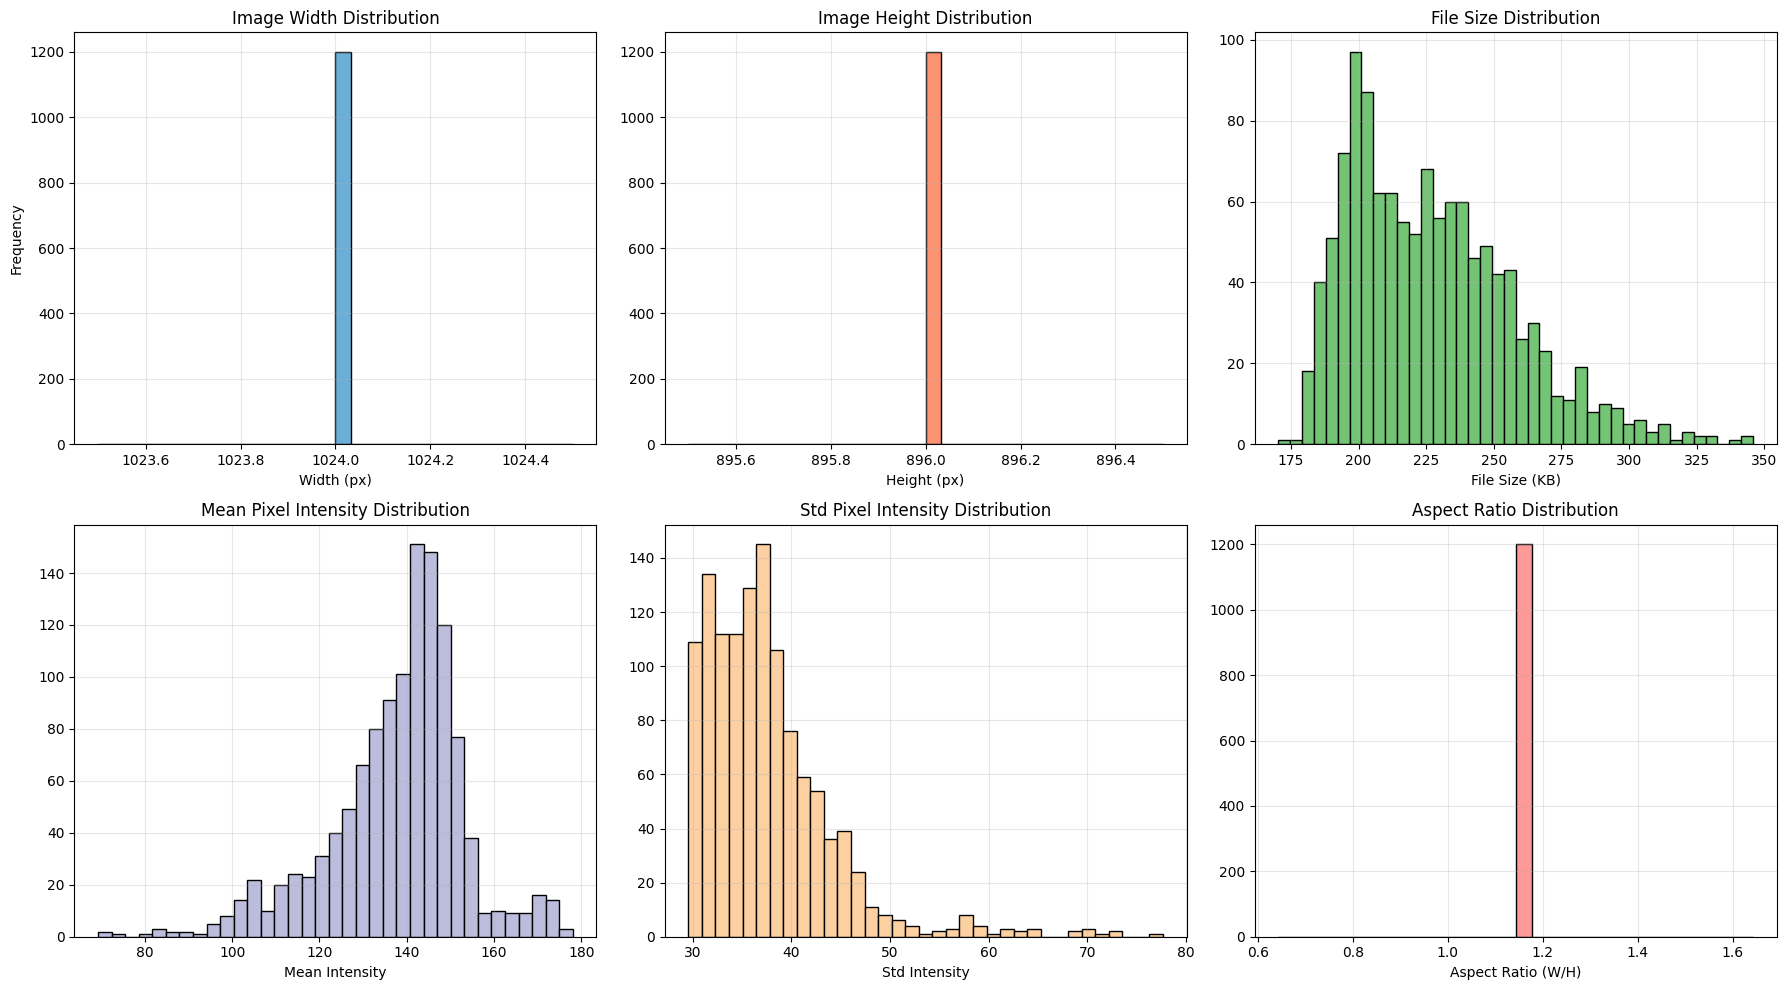

✓ Saved: 00_image_properties.png
✓ Saved: image_properties_sample.csv


In [3]:
#####
# Step 3A: Image Property Distributions
#####

from tqdm.auto import tqdm
import os

def compute_image_stats(df, max_images=1000, seed=RANDOM_SEED):
    if len(df) == 0:
        return pd.DataFrame()
    sample_df = df.sample(min(len(df), max_images), random_state=seed)
    rows = []
    for p in tqdm(sample_df["full_path"], desc="Computing image stats"):
        try:
            im = Image.open(p).convert("RGB")
            arr = np.asarray(im)
            h, w = arr.shape[:2]
            gray = np.dot(arr[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)
            size_kb = os.path.getsize(p) / 1024.0
            rows.append({
                "path": p,
                "width": w,
                "height": h,
                "file_kb": size_kb,
                "mean_intensity": float(gray.mean()),
                "std_intensity": float(gray.std()),
                "aspect_ratio": w / h if h > 0 else np.nan,
            })
        except Exception as e:
            # skip unreadable images
            continue
    return pd.DataFrame(rows)

stats_df = compute_image_stats(df_merged, max_images=1200)

if len(stats_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    axes[0,0].hist(stats_df["width"], bins=30, color="#6baed6", edgecolor="black")
    axes[0,0].set_title("Image Width Distribution"); axes[0,0].set_xlabel("Width (px)"); axes[0,0].set_ylabel("Frequency")

    axes[0,1].hist(stats_df["height"], bins=30, color="#fc9272", edgecolor="black")
    axes[0,1].set_title("Image Height Distribution"); axes[0,1].set_xlabel("Height (px)")

    axes[0,2].hist(stats_df["file_kb"], bins=40, color="#74c476", edgecolor="black")
    axes[0,2].set_title("File Size Distribution"); axes[0,2].set_xlabel("File Size (KB)")

    axes[1,0].hist(stats_df["mean_intensity"], bins=35, color="#bcbddc", edgecolor="black")
    axes[1,0].set_title("Mean Pixel Intensity Distribution"); axes[1,0].set_xlabel("Mean Intensity")

    axes[1,1].hist(stats_df["std_intensity"], bins=35, color="#fdd0a2", edgecolor="black")
    axes[1,1].set_title("Std Pixel Intensity Distribution"); axes[1,1].set_xlabel("Std Intensity")

    axes[1,2].hist(stats_df["aspect_ratio"], bins=30, color="#fb9a99", edgecolor="black")
    axes[1,2].set_title("Aspect Ratio Distribution"); axes[1,2].set_xlabel("Aspect Ratio (W/H)")

    for ax in axes.ravel():
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "00_image_properties.png", dpi=300, bbox_inches="tight")
    plt.show()
    stats_df.to_csv(DATA_ANALYSIS_DIR / "image_properties_sample.csv", index=False)
    print("✓ Saved: 00_image_properties.png")
    print("✓ Saved: image_properties_sample.csv")
else:
    print("⚠ No image stats computed (dataset empty?).")


3B - Sample Gallery Across Classes

/tmp/ipython-input-165940528.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=RANDOM_SEED))


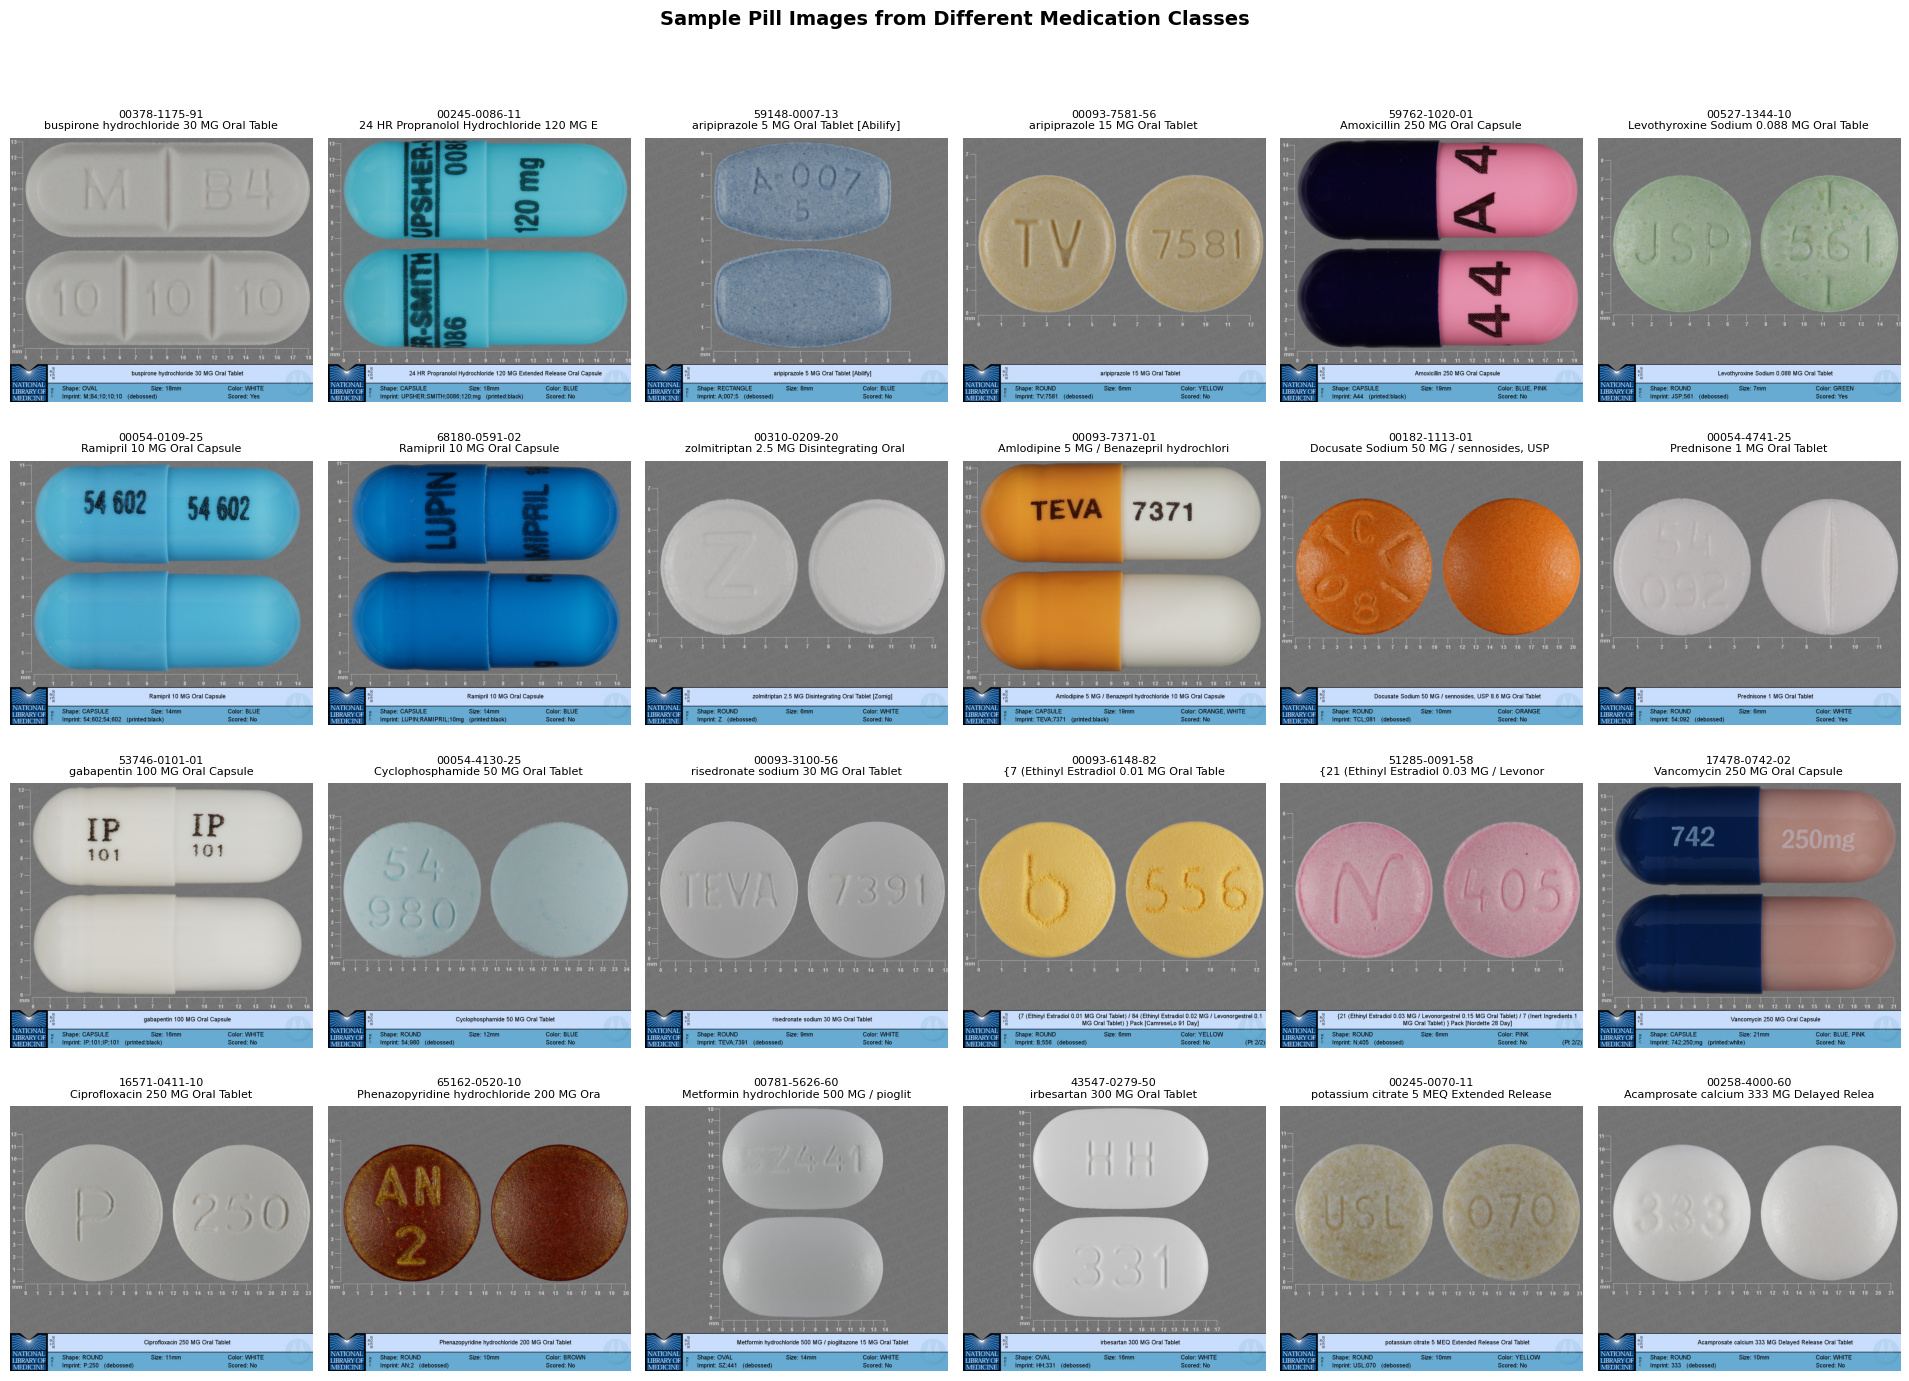

✓ Saved: 04_sample_gallery.png


In [4]:
def contact_sheet(df, n_rows=4, n_cols=6, per_class=True,
                  title="Sample Pill Images from Different Medication Classes",
                  save_name="04_sample_gallery.png"):
    if len(df) == 0:
        print("⚠ Dataset empty; skipping gallery.")
        return
    capacity = n_rows * n_cols
    uniq_classes = df["ndc11"].nunique() if "ndc11" in df.columns else 0

    if per_class and uniq_classes >= 2:
        # Try to maximize variety: one image per class
        picks = (df.groupby("ndc11", group_keys=False)
                   .apply(lambda g: g.sample(1, random_state=RANDOM_SEED))
                   .reset_index(drop=True))
        # Fill grid
        if len(picks) >= capacity:
            grid_df = picks.sample(capacity, random_state=RANDOM_SEED)
        else:
            # use all unique-class picks, then fill remainder from the full df
            remainder = capacity - len(picks)
            add_df = df.sample(remainder, replace=(len(df) < remainder), random_state=RANDOM_SEED)
            grid_df = pd.concat([picks, add_df], ignore_index=True)
    else:
        # Ignore class balancing; just show images
        grid_df = df.sample(min(len(df), capacity), random_state=RANDOM_SEED)
        if len(grid_df) < capacity:
            # top up with replacement so we always fill the grid
            extra = df.sample(capacity - len(grid_df), replace=True, random_state=RANDOM_SEED)
            grid_df = pd.concat([grid_df, extra], ignore_index=True)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3.6*n_rows))
    fig.suptitle(title, fontsize=14, fontweight="bold")

    for ax, (_, row) in zip(axes.ravel(), grid_df.iterrows()):
        try:
            ax.imshow(Image.open(row["full_path"]).convert("RGB"))
        except Exception:
            ax.imshow(Image.new("RGB", (224,224), color="white"))
        label = str(row.get("ndc11", "UNKNOWN"))
        name  = str(row.get("name", ""))[:40]
        ax.set_title(f"{label}\n{name}", fontsize=8)
        ax.axis("off")

    # hide any unused axes (should be none)
    for ax in axes.ravel()[len(grid_df):]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(PLOTS_DIR / save_name, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved: {save_name}")

# Call it (variety-first, but auto-fills the grid)
contact_sheet(df_merged, n_rows=4, n_cols=6, per_class=True, save_name="04_sample_gallery.png")

Step 4 - Retrieval Data: Define df_index (all images) and an evaluation subset (NDCs with ≥2 images).

In [5]:
#####
# Step 4: Prepare Retrieval Dataset
#####

print("\n" + "="*80)
print("STEP 4: PREPARE RETRIEVAL DATASET")
print("="*80 + "\n")

# For retrieval, index all images
df_index = df_merged.copy().reset_index(drop=True)

# Classes with ≥2 images (needed for meaningful LOO evaluation)
counts = df_index["ndc11"].value_counts()
eval_candidate_ndcs = counts[counts >= 2].index.tolist()
df_eval_candidates = df_index[df_index["ndc11"].isin(eval_candidate_ndcs)].reset_index(drop=True)

print(f"Index images: {len(df_index):,}")
print(f"NDCs with ≥2 images: {len(eval_candidate_ndcs):,} "
      f"covering {len(df_eval_candidates):,} images "
      f"({len(df_eval_candidates)/len(df_index)*100:.1f}%)")

df_index[["full_path","ndc11","name","image_type"]].to_csv(DATA_ANALYSIS_DIR / "index_dataset.csv", index=False)
df_eval_candidates[["full_path","ndc11","name","image_type"]].to_csv(DATA_ANALYSIS_DIR / "eval_candidates.csv", index=False)
print("✓ Saved index_dataset.csv and eval_candidates.csv")


STEP 4: PREPARE RETRIEVAL DATASET

Index images: 4,392
NDCs with ≥2 images: 117 covering 329 images (7.5%)
✓ Saved index_dataset.csv and eval_candidates.csv


Step 5 - Compute and L2‑normalize CLIP (ViT‑B/32) embeddings

In [6]:
#####
# Step 5: Embed Images with CLIP (ViT-B/32) — DataLoader-free, robust version
#####

print("\n" + "="*80)
print("STEP 5: EMBED IMAGES WITH CLIP")
print("="*80 + "\n")

from transformers import CLIPModel, CLIPProcessor
from tqdm.auto import tqdm

EMBEDDER_NAME = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(EMBEDDER_NAME).to(device)
clip_processor = CLIPProcessor.from_pretrained(EMBEDDER_NAME)
clip_model.eval()

def compute_embeddings_no_loader(df, batch_size=64):
    paths = df["full_path"].tolist()
    emb_dim = int(getattr(clip_model.config, "projection_dim",
                          getattr(clip_model, "visual_projection").out_features))
    feats_all = np.zeros((len(paths), emb_dim), dtype=np.float32)
    bad = []

    with torch.no_grad():
        for start in tqdm(range(0, len(paths), batch_size), desc="Embedding"):
            chunk = paths[start:start+batch_size]
            images = []
            for p in chunk:
                try:
                    images.append(Image.open(p).convert("RGB"))
                except Exception as e:
                    bad.append((p, str(e)))
                    images.append(Image.new("RGB", (224, 224), color="white"))

            inputs = clip_processor(images=images, return_tensors="pt", padding=True).to(device)
            feats = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
            feats = torch.nn.functional.normalize(feats, p=2, dim=1)
            feats_all[start:start+len(images)] = feats.float().cpu().numpy()

    if bad:
        with open(MODELS_DIR / "step5_bad_images.json", "w") as f:
            json.dump(bad, f, indent=2)
        print(f"⚠ Replaced {len(bad)} unreadable images with placeholders "
              f"(logged to step5_bad_images.json).")
    return feats_all

# You can lower batch_size if you hit GPU memory limits (e.g., 32 or 16)
image_embeddings = compute_embeddings_no_loader(df_index, batch_size=64)
np.save(MODELS_DIR / "image_embeddings.npy", image_embeddings)
df_index[["full_path","ndc11","name","image_type"]].to_csv(MODELS_DIR / "index_metadata.csv", index=False)
print(f"✓ Saved embeddings: {image_embeddings.shape} -> image_embeddings.npy")
print("✓ Saved index_metadata.csv")


STEP 5: EMBED IMAGES WITH CLIP



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Embedding:   0%|          | 0/69 [00:00<?, ?it/s]

✓ Saved embeddings: (4392, 512) -> image_embeddings.npy
✓ Saved index_metadata.csv


ST 6 - Index + Heatmap


STEP 6: BUILD INDEX + SIMILARITY HEATMAP

✓ Built sklearn NearestNeighbors index (cosine)


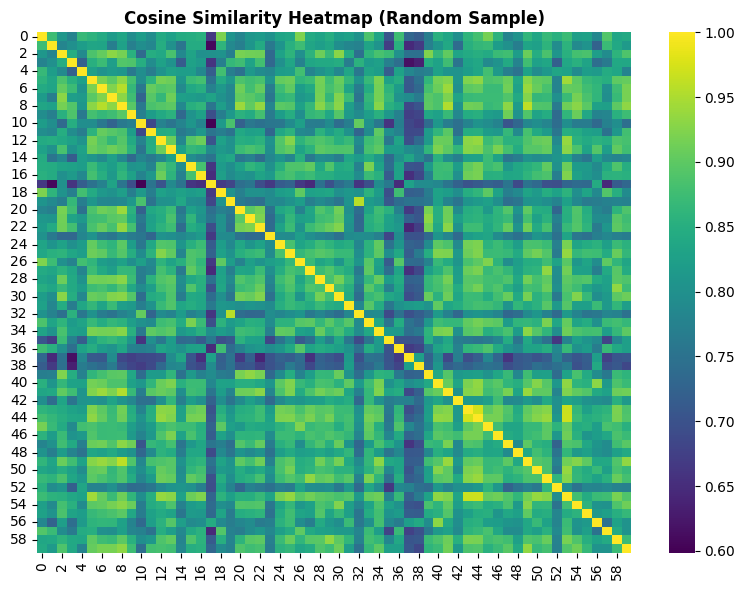

✓ Saved: 03_similarity_heatmap.png


In [7]:
#####
# Step 6: Build Similarity Index (FAISS or sklearn) + Similarity Heatmap
#####

print("\n" + "="*80)
print("STEP 6: BUILD INDEX + SIMILARITY HEATMAP")
print("="*80 + "\n")

use_faiss = False
try:
    import faiss
    d = image_embeddings.shape[1]
    faiss_index = faiss.IndexFlatIP(d)  # cosine on normalized vectors == inner product
    faiss_index.add(image_embeddings.astype(np.float32))
    faiss.write_index(faiss_index, str(MODELS_DIR / "image_index.faiss"))
    use_faiss = True
    print("✓ Built FAISS index (inner product)")
except Exception as e:
    from sklearn.neighbors import NearestNeighbors
    nn_index = NearestNeighbors(metric="cosine", n_neighbors=min(100, len(image_embeddings)))
    nn_index.fit(image_embeddings)
    joblib.dump(nn_index, MODELS_DIR / "image_index_sklearn.pkl")
    print("✓ Built sklearn NearestNeighbors index (cosine)")

# Similarity heatmap (sample up to 60 images)
n_sample = min(60, len(df_index))
if n_sample >= 2:
    sample_idx = np.random.RandomState(RANDOM_SEED).choice(len(df_index), size=n_sample, replace=False)
    M = image_embeddings[sample_idx]
    sim = (M @ M.T)  # cosine (already normalized)
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim, cmap="viridis")
    plt.title("Cosine Similarity Heatmap (Random Sample)", fontweight="bold")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "03_similarity_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved: 03_similarity_heatmap.png")
else:
    print("Not enough samples for heatmap; skipping.")

Step 7 - Retrieval Helpers(cosine similarity)

In [8]:
#####
# Step 7: Retrieval Helpers (Embed Query + Top-k Search)
#####

def embed_single_image(img_path: str) -> np.ndarray:
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error opening query image {img_path}: {e}")
        img = Image.new('RGB', (224, 224), color='white')
    with torch.no_grad():
        inputs = clip_processor(images=img, return_tensors='pt').to(device)
        feats = clip_model.get_image_features(pixel_values=inputs['pixel_values'])
        feats = torch.nn.functional.normalize(feats, p=2, dim=1)
    return feats.cpu().numpy().astype(np.float32)[0]

def search_topk(query_vec: np.ndarray, k=5, exclude_index: int | None = None, dedup_ndc=True):
    if use_faiss:
        want = min(len(image_embeddings), k*8 if dedup_ndc else k)
        sims, idxs = faiss_index.search(query_vec[None, :].astype(np.float32), want)
        pairs = [(int(i), float(s)) for i, s in zip(idxs[0], sims[0])]
    else:
        want = min(len(image_embeddings), k*8 if dedup_ndc else k)
        dists, idxs = nn_index.kneighbors(query_vec.reshape(1, -1), n_neighbors=want, return_distance=True)
        pairs = [(int(i), float(1.0 - d)) for i, d in zip(idxs[0], dists[0])]

    # Optionally exclude the exact same image
    if exclude_index is not None:
        pairs = [(i, s) for i, s in pairs if i != exclude_index]

    # Deduplicate by NDC if requested
    results, seen_ndc = [], set()
    for i, s in pairs:
        ndc = df_index.loc[i, "ndc11"]
        if (not dedup_ndc) or (ndc not in seen_ndc):
            results.append((i, s))
            seen_ndc.add(ndc)
        if len(results) >= k:
            break

    out = []
    for i, s in results:
        row = df_index.loc[i]
        out.append({
            "rank": len(out)+1,
            "similarity": round(s, 4),
            "ndc11": row["ndc11"],
            "name": row["name"],
            "image_path": row["full_path"],
            "image_type": row.get("image_type", "NA")
        })
    return out

def retrieve(image_path: str, k=5, dedup_ndc=True):
    q = embed_single_image(image_path)
    return search_topk(q, k=k, dedup_ndc=dedup_ndc)

print("✓ Retrieval helpers ready.")

✓ Retrieval helpers ready.


Step 8 - Evaluation

In [9]:
#####
# Step 8: Leave-One-Out Evaluation (Recall@K, MRR)
#####

from tqdm.auto import tqdm

def evaluate_retrieval(k_list=(1,5,10), max_queries=400):
    # Restrict to classes with ≥2 images
    eligible = df_index["ndc11"].value_counts()
    eligible_ndcs = set(eligible[eligible >= 2].index)
    eligible_indices = df_index.index[df_index["ndc11"].isin(eligible_ndcs)].tolist()

    if len(eligible_indices) == 0:
        print("⚠ No NDC has ≥2 images. Retrieval evaluation is skipped.")
        return {k: np.nan for k in k_list}, np.nan, pd.DataFrame()

    q_indices = np.random.RandomState(RANDOM_SEED).choice(
        eligible_indices, size=min(len(eligible_indices), max_queries), replace=False
    )

    recall_hits = {k: 0 for k in k_list}
    rr_total = 0.0
    eval_rows = []

    for qi in tqdm(q_indices, desc="Evaluating (LOO)"):
        q_vec = image_embeddings[qi]
        q_ndc = df_index.loc[qi, "ndc11"]
        results = search_topk(q_vec, k=max(k_list), exclude_index=qi, dedup_ndc=True)

        # rank of first correct NDC
        rank = None
        for r in results:
            if r["ndc11"] == q_ndc:
                rank = r["rank"]
                break

        for k in k_list:
            if rank is not None and rank <= k:
                recall_hits[k] += 1

        rr_total += (1.0 / rank) if rank is not None else 0.0

        eval_rows.append({
            "query_index": int(qi),
            "query_ndc": q_ndc,
            "first_correct_rank": int(rank) if rank is not None else None
        })

    m = len(q_indices)
    recall = {k: recall_hits[k] / m for k in k_list}
    mrr = rr_total / m
    eval_df = pd.DataFrame(eval_rows)
    eval_df.to_csv(MODELS_DIR / "retrieval_eval_loo.csv", index=False)
    return recall, mrr, eval_df

recall, mrr, _ = evaluate_retrieval(k_list=(1,5,10), max_queries=400)
print(f"Recall@1: {recall[1]:.3f} | Recall@5: {recall[5]:.3f} | Recall@10: {recall[10]:.3f} | MRR: {mrr:.3f}")
print("✓ Saved retrieval_eval_loo.csv")

Evaluating (LOO):   0%|          | 0/329 [00:00<?, ?it/s]

Recall@1: 0.128 | Recall@5: 0.255 | Recall@10: 0.319 | MRR: 0.182
✓ Saved retrieval_eval_loo.csv


Step 9 - Plot a query plus top‑k results in a single panel for reports and slides.

In [10]:
#####
# Step 9: Demo — Query + Visualize Top-k Results
#####

def show_topk(query_path: str, k=5, dedup_ndc=True, save_name="04_retrieval_demo.png"):
    q = embed_single_image(query_path)
    results = search_topk(q, k=k, dedup_ndc=dedup_ndc)

    plt.figure(figsize=(3*(k+1), 4))
    # Query image
    ax = plt.subplot(1, k+1, 1)
    try:
        ax.imshow(Image.open(query_path).convert('RGB'))
    except Exception:
        ax.imshow(Image.new('RGB', (224,224), color='white'))
    ax.set_title("Query", fontweight='bold')
    ax.axis('off')

    # Results
    for i, r in enumerate(results, start=2):
        ax = plt.subplot(1, k+1, i)
        try:
            ax.imshow(Image.open(r['image_path']).convert('RGB'))
        except Exception:
            ax.imshow(Image.new('RGB', (224,224), color='white'))
        short_ndc = r['ndc11'] if len(str(r['ndc11'])) <= 14 else str(r['ndc11'])[:14] + "…"
        ax.set_title(f"#{r['rank']} • {r['similarity']:.3f}\n{short_ndc}", fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    out_path = PLOTS_DIR / save_name
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_name}")
    return results



## 🚀 **Demo**

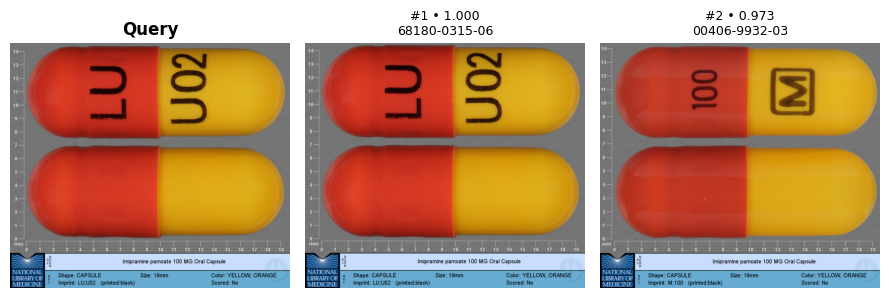

✓ Saved: 04_retrieval_demo.png
✓ Saved retrieval_demo_results.csv


In [16]:
# Example usage (uncomment to run):
if len(df_index) > 0:
    query_img = df_index.sample(1, random_state=RANDOM_SEED).iloc[0]["full_path"]
    demo_results = show_topk(query_img, k=2, dedup_ndc=True)
    pd.DataFrame(demo_results).to_csv(MODELS_DIR / "retrieval_demo_results.csv", index=False)
    print("✓ Saved retrieval_demo_results.csv")

## 🚀 **Interactive Demo**

Upload or provide a path to an image, run retrieval, and save panel + CSV.

Upload a query image (.jpg/.png/.jpeg)...


Saving 65162-0536-10_RXNAVIMAGE10_8835445A.jpg to 65162-0536-10_RXNAVIMAGE10_8835445A (1).jpg
Query image: /content/outputs/queries/65162-0536-10_RXNAVIMAGE10_8835445A (1).jpg


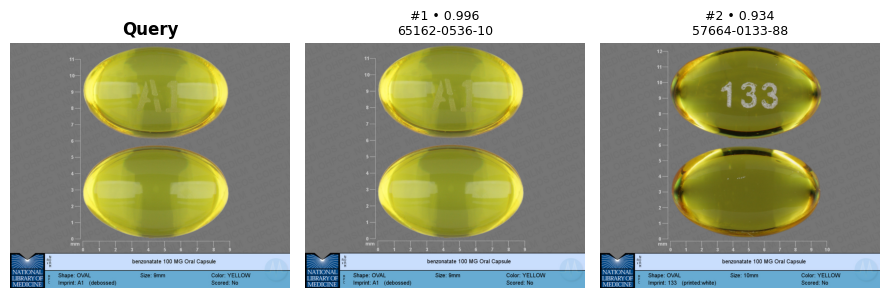

✓ Saved: 07_query_65162-0536-10_RXNAVIMAGE10_8835445A (1)_top2.png
✓ Saved: 07_query_65162-0536-10_RXNAVIMAGE10_8835445A (1)_top2.png
✓ Saved: retrieval_results_65162-0536-10_RXNAVIMAGE10_8835445A (1).csv


In [18]:
#####
# Step 9A: Interactive Demo — Upload or Select an Image
#####

from pathlib import Path
import shutil
import pandas as pd

def demo_prompted_image(k=5, dedup_ndc=True):
    qpath = None

    # 1) Try Colab upload first
    try:
        from google.colab import files as colab_files
        print("Upload a query image (.jpg/.png/.jpeg)...")
        uploaded = colab_files.upload()
        if uploaded:
            fname = list(uploaded.keys())[0]
            qdir = OUTPUT_DIR / "queries"
            qdir.mkdir(parents=True, exist_ok=True)
            qpath = str(qdir / fname)
            with open(qpath, "wb") as f:
                f.write(uploaded[fname])
    except Exception:
        pass

    # 2) Fallback to manual path input if not in Colab or no file chosen
    if qpath is None:
        qpath_in = input("Enter the full path to a local image (.jpg/.png): ").strip().strip('"').strip("'")
        if not qpath_in:
            print("No path provided; aborting.")
            return None
        if not Path(qpath_in).exists():
            print(f"Path not found: {qpath_in}")
            return None
        qdir = OUTPUT_DIR / "queries"
        qdir.mkdir(parents=True, exist_ok=True)
        dest = qdir / Path(qpath_in).name
        # Copy to outputs/queries for reproducibility
        try:
            if Path(qpath_in).resolve() != dest.resolve():
                shutil.copy(qpath_in, dest)
            qpath = str(dest)
        except Exception:
            qpath = qpath_in  # fallback without copy

    print(f"Query image: {qpath}")

    # 3) Retrieve and visualize using existing Step 9 helper
    results = show_topk(
        qpath, k=k, dedup_ndc=dedup_ndc,
        save_name=f"07_query_{Path(qpath).stem}_top{k}.png"
    )

    # 4) Save numeric results
    pd.DataFrame(results).to_csv(
        MODELS_DIR / f"retrieval_results_{Path(qpath).stem}.csv",
        index=False
    )
    print(f"✓ Saved: 07_query_{Path(qpath).stem}_top{k}.png")
    print(f"✓ Saved: retrieval_results_{Path(qpath).stem}.csv")
    return results

# Run the interactive demo like this:
demo_results = demo_prompted_image(k=2, dedup_ndc=True)

Step 10 - Mini API: Lightweight class to load the index and run programmatic queries anywhere.

In [19]:
#####
# Step 10: Lightweight API Wrapper for Inference
#####

class PillRetrieval:
    def __init__(self, device=device):
        self.device = device
        self.df = pd.read_csv(MODELS_DIR / "index_metadata.csv")
        self.embeddings = np.load(MODELS_DIR / "image_embeddings.npy")
        self.use_faiss = False
        # Try FAISS
        try:
            import faiss
            idx = faiss.read_index(str(MODELS_DIR / "image_index.faiss"))
            self.faiss_index = idx
            self.use_faiss = True
        except Exception:
            self.faiss_index = None
            self.nn_index = joblib.load(MODELS_DIR / "image_index_sklearn.pkl")
        # Load CLIP
        from transformers import CLIPModel, CLIPProcessor
        self.model = CLIPModel.from_pretrained(EMBEDDER_NAME).to(self.device).eval()
        self.proc = CLIPProcessor.from_pretrained(EMBEDDER_NAME)

    def embed(self, image_path: str) -> np.ndarray:
        try:
            img = Image.open(image_path).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224,224), color='white')
        with torch.no_grad():
            inputs = self.proc(images=img, return_tensors='pt').to(self.device)
            feats = self.model.get_image_features(pixel_values=inputs['pixel_values'])
            feats = torch.nn.functional.normalize(feats, p=2, dim=1)
        return feats.cpu().numpy().astype(np.float32)[0]

    def search(self, query_vec: np.ndarray, k=5, dedup_ndc=True):
        if self.use_faiss:
            sims, idxs = self.faiss_index.search(query_vec[None, :].astype(np.float32), min(len(self.embeddings), k*8 if dedup_ndc else k))
            pairs = [(int(i), float(s)) for i, s in zip(idxs[0], sims[0])]
        else:
            want = min(len(self.embeddings), k*8 if dedup_ndc else k)
            dists, idxs = self.nn_index.kneighbors(query_vec.reshape(1, -1), n_neighbors=want, return_distance=True)
            pairs = [(int(i), float(1.0 - d)) for i, d in zip(idxs[0], dists[0])]

        results, seen_ndc = [], set()
        for i, s in pairs:
            ndc = self.df.loc[i, "ndc11"]
            if (not dedup_ndc) or (ndc not in seen_ndc):
                row = self.df.loc[i]
                results.append({
                    "rank": len(results)+1,
                    "similarity": round(s, 4),
                    "ndc11": row["ndc11"],
                    "name": row["name"],
                    "image_path": row["full_path"],
                    "image_type": row.get("image_type", "NA")
                })
                seen_ndc.add(ndc)
            if len(results) >= k:
                break
        return results

    def retrieve(self, image_path: str, k=5, dedup_ndc=True):
        q = self.embed(image_path)
        return self.search(q, k=k, dedup_ndc=dedup_ndc)

print("\nAll steps completed. Retrieval pipeline is ready.")


All steps completed. Retrieval pipeline is ready.
